# Investigation of geophysical sensor data to inform priors

Since we don't have a really great idea of what constitutes a good set of priors for real data, here I try my best to sort out what is going on using what I hope will be simple, but robust, assumptions.

In [1]:
import GPy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
%matplotlib inline

## Noise and length scale characteristics for gravity and magnetism

We've been running with some set of priors for gravity and magnetism, but in all fairness we have no idea what those should be.  We know they're both linear sensors that integrate over rock properties, with a 3-D sensitivity profile that gets broader with depth.  So by fitting a GP to them, we get some idea of the noise, and a lower limit on the relevant length scale.  Since they're on a grid, we could also consider the autocorrelation.

This isn't really meant to be a Bayesian analysis, but it's meant to give us some idea of the order of magnitude of the noise in a model that's flexible enough to respond to changes, but that insists on smoothness so we can pick off the delta-function component of the covariance.

# Data dictionaries

In [2]:
length_grav = 0.05
length_mag = 0.015

lat_centre = -24.85
lon_centre = 116.1

gda94 = pyproj.Proj(init='epsg:4283')
mgaz50 = pyproj.Proj(init='epsg:28350')
agd84 = pyproj.Proj(init='epsg:4203')
#agd84 = pyproj.Proj(init='eps:20350')

degree_conversion = 111111
length_grav_metres = length_grav * degree_conversion
length_mag_metres = length_mag * degree_conversion

eastings_centre, northings_centre = pyproj.transform(gda94, mgaz50, lon_centre, lat_centre)
agd_x_centre, agd_y_centre = pyproj.transform(gda94, agd84, lon_centre, lat_centre)

In [4]:
y2 = (lat_centre + length_grav)
_, y2_boundary = pyproj.transform(gda94, mgaz50, lon_centre, y2)
print(y2_boundary)
print(northings_centre)
print(y2_boundary - northings_centre)
length_grav_metres = y2_boundary - northings_centre

7256897.973415146
7251361.229105394
5536.744309751317


In [18]:
dict_data_set1 = {
    'dir_data': '/Users/davidkohn/dev/obsidian/data/dataset1',
    'grav': {
        'fname': 'gravity_400m_Gascoyne.txt',
        'key_lat': 'Latitude',
        'key_lon': 'Longitude',
        'key_y': 'grid_code',
    },
    'mag': {
        'fname': 'mag_TMI_gascoyne.txt',
        'key_lat': 'Latitude',
        'key_lon': 'Longitude',
        'key_y': 'grid_code',
    },
}

dict_data_set2 = {
    'dir_data': '/Users/davidkohn/dev/obsidian/data/dataset2',
    'grav_north': {
        'fname': 'Gascoyne_North_Bouguer_gravity_400m_XYZ.txt',
        'key_lat': 'Y',
        'key_lon': 'X',
        'key_y': 'GASCOYNE_NORTH_1',
    },
    'grav_south': {
        'fname': 'Gascoyne_South_Bouguer_gravity_500m_XYZ.txt',
        'key_lat': 'Y',
        'key_lon': 'X',
        'key_y': 'GASCOYNE_SOUTH_1',
    },
    'mag': {
        'fname': 'Bangemall_mag_125m_XYZ.txt',
        'key_lat': 'Y',
        'key_lon': 'X',
        'key_y': 'MAG_PD',
    },
}

dict_data_set3 = {
    'dir_data': '/Users/davidkohn/dev/obsidian/data/dataset3',
    'grav_north': {
        'fname': 'Gascoyne_North_2010_gravity_line_data_all.xlsx',
        'key_lat': 'COORDINATE LATITUDE GDA94 (DECIMAL DEGREES)',
        'key_lon': 'COORDINATE LONGITUDE GDA94 (DECIMAL DEGREES)',
        'key_z': 'GROUND LEVEL ELEVATION (M)',
        'key_y': 'COMPLETE SPHERICAL CAP BOUGUER ANOMALY 2.67 t/m^3 (GU)',
    },
    'grav_south': {
        'fname': 'Gascoyne_South_2010_gravity_line_data_all.xlsx',
        'key_lat': 'COORDINATE LATITUDE GDA94 (DECIMAL DEGREES)',
        'key_lon': 'COORDINATE LONGITUDE GDA94 (DECIMAL DEGREES)',
        'key_z': 'GROUND LEVEL ELEVATION (M)',
        'key_y': 'COMPLETE SPHERICAL CAP BOUGUER ANOMALY 2.67 t/m^3 (GU)',
    },
    'mag1': {
        'fname': 'bangemall_1.asc',
        'key_lat': 'latitude',
        'key_lon': 'longitude',
        'key_y': 'mag corrected',
    },
    'mag2': {
        'fname': 'bangemall_2.asc',
        'key_lat': 'latitude',
        'key_lon': 'longitude',
        'key_y': 'mag corrected',
    },
}

# Functions

In [6]:
msg_str0 = 'fpath: {}'
msg_str1 = '  Latitude min: {}\n  Latitude max: {}'
msg_str2 = '  Grid code min: {}\n  Grid code max: {}'
msg_str3 = '  Data shape: {}'
msg_str4 = '  X shape: {}\n  Y shape: {}'
msg_str5 = '  Data columns: {}'

def get_vars(dict_data_set, sub_key):
    dir_data = dict_data_set['dir_data']
    fname_data = dict_data_set[sub_key]['fname']
    fpath_data = os.path.join(dir_data, fname_data)
    key_lat = dict_data_set[sub_key]['key_lat']
    key_lon = dict_data_set[sub_key]['key_lon']
    key_y = dict_data_set[sub_key]['key_y']
    return(fpath_data, key_lon, key_lat, key_y)

def get_data(
    fpath,
    ftype = 'txt'
):
    msg_str = msg_str0.format(fpath)
    print(msg_str)
    if (ftype == 'csv') or (ftype == 'txt'):
        data = pd.read_csv(fpath, header=0)
    elif (ftype == 'xlsx'):
        data = pd.read_excel(fpath, header=0)
    elif (ftype == 'asc'):
        data = pd.read_csv(fpath, sep = ' ')
    msg_str = msg_str3.format(data.shape)
    print(msg_str)
    msg_str = msg_str5.format(data.columns)
    print(msg_str)
    return(data)

def get_data_that_is_in_square_around_centre(
    data, 
    centres,
    keys,
    lengths
):
    """
    Subtract the centre coordinates of the region
    and then see whether the "centred coordinates"
    are within the region specified by length.
    """
    msg_str = 'centres: {}\nkeys: {}\nlengths: {}'.format(centres, keys, lengths)
    print(msg_str)
    print('data.shape before: {}'.format(data.shape))
    for length, key, centre in zip(lengths, keys, centres):
        cond = np.abs(np.abs(data[key]) - np.abs(centre)) < length
        #cond = np.abs(data[key] - centre) < length
        data = data[cond]
    data.reset_index(inplace = True)
    print('data.shape after: {}'.format(data.shape))
    return(data)

def run_gp(
    data, key_lat, key_lon, key_y,
    ARD = False
):
    print('Running GP')
    X = np.array([data[key_lat], data[key_lon]]).T
    Y = np.array([data[key_y]]).T
    kernel = GPy.kern.Matern32(2, ARD = ARD)
    msg_str = msg_str4.format(X.shape, Y.shape)
    model = GPy.models.GPRegression(X, Y, kernel)
    model.optimize(messages=True)
    fig = plt.figure(figsize = (10, 10))
    print(model)
    f = model.plot()
    return(X, Y, model)

# Dataset1: grav

In [ ]:
dict_data_set = dict_data_set1
sub_key = 'grav'
length = length_grav

fpath_data, key_x_coord, key_y_coord, key_y = get_vars(dict_data_set, sub_key)
data = get_data(fpath_data)

data_centred = get_data_that_is_in_square_around_centre(
    data,
    [lon_centre, lat_centre],
    [key_x_coord, key_y_coord],
    [length, length]
)

X, Y, model = run_gp(data_centred, key_x_coord, key_y_coord, key_y)

In [ ]:
f = model.plot()
plt.savefig('/Users/davidkohn/Desktop/dataset1-grav.png')

In [ ]:
print(data_centred[key_y_coord].max())
print(data_centred[key_y_coord].min())

# Dataset1: mag

In [ ]:
dict_data_set = dict_data_set1
sub_key = 'mag'
length = length_mag

fpath_data, key_x_coord, key_y_coord, key_y = get_vars(dict_data_set, sub_key)
data = get_data(fpath_data)

data_centred = get_data_that_is_in_square_around_centre(
    data,
    [lon_centre, lat_centre],
    [key_x_coord, key_y_coord],
    [length, length]
)

X, Y, model = run_gp(data_centred, key_x_coord, key_y_coord, key_y)

In [ ]:
f = model.plot()
plt.savefig('/Users/davidkohn/Desktop/dataset1-mag.png')

# Dataset2: grav_north

In [ ]:
dict_data_set = dict_data_set2
sub_key = 'grav_north'
length = length_grav_metres

fpath_data, key_x_coord, key_y_coord, key_y = get_vars(dict_data_set, sub_key)
data = get_data(fpath_data)

data_centred = get_data_that_is_in_square_around_centre(
    data,
    [eastings_centre, northings_centre],
    [key_x_coord, key_y_coord],
    [length, length]
)

data_centred[key_y] = data_centred[key_y] - data_centred[key_y].mean()

#X, Y, model = run_gp(data_centred, key_x_coord, key_y_coord, key_y)

new_key_x_coord = 'lon'
new_key_y_coord = 'lat'

data_centred[new_key_x_coord] = 0
data_centred[new_key_y_coord] = 0
for idx, (x, y) in enumerate(zip(data_centred[key_x_coord], data_centred[key_y_coord])):
    lon, lat = pyproj.transform(mgaz50, gda94, x, y)
    #print(lon, lat)
    data_centred.loc[idx, new_key_x_coord] = lon
    data_centred.loc[idx, new_key_y_coord] = lat

X, Y, model = run_gp(data_centred, new_key_x_coord, new_key_y_coord, key_y)

In [ ]:
print(data_centred[key_y_coord].max())
print(data_centred[key_y_coord].min())

print(pyproj.transform(mgaz50, gda94, data_centred[key_x_coord].max(), data_centred[key_y_coord].max()))
print(pyproj.transform(mgaz50, gda94, data_centred[key_x_coord].min(), data_centred[key_y_coord].min()))

In [ ]:
data_new = centre_data(data, length, 'lon', 'lat', lat_centre, lon_centre)

In [ ]:
f = model.plot()
plt.savefig('/Users/davidkohn/Desktop/dataset2-grav-north.png')

# Dataset2: mag

fpath: /Users/davidkohn/dev/obsidian/data/dataset2/Bangemall_mag_125m_XYZ.txt


 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning:Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


  Data shape: (4187429, 4)
  Data columns: Index(['Rowid_', 'X', 'Y', 'MAG_PD'], dtype='object')
centres: [409068.8755808186, 7251361.229105394]
keys: ['X', 'Y']
lengths: [1500, 1500]
data.shape before: (4187429, 4)
data.shape after: (576, 5)
Running GP
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s15  0003   8.785120e+06   1.023752e+13 
    01s16  0022   1.653738e+04   1.352589e+06 
    03s20  0063   3.159759e+03   1.547515e+04 
    03s64  0072   3.156234e+03   1.378195e-05 
Runtime:     03s64
Optimization status: Converged


Name : GP regression
Objective : 3156.2342754186034
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  Mat32.variance           |       51892.1233654  |      +ve      |        
  Mat32.lengthscale        |    0.00379013917719  |      +ve      |        
  Gaussian_noise.variance  |  5.56268464627e

 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


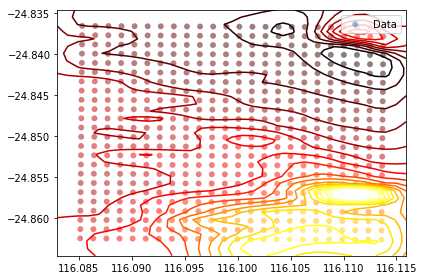

In [11]:
dict_data_set = dict_data_set2
sub_key = 'mag'
length = 1500

fpath_data, key_x_coord, key_y_coord, key_y = get_vars(dict_data_set, sub_key)
data = get_data(fpath_data)

data_centred = get_data_that_is_in_square_around_centre(
    data,
    [eastings_centre, northings_centre],
    [key_x_coord, key_y_coord],
    [length, length]
)

data_centred[key_y] = data_centred[key_y].astype('float64')
data_centred[key_y] = data_centred[key_y] - data_centred[key_y].mean()

#X, Y, model = run_gp(data_centred, key_x_coord, key_y_coord, key_y)

new_key_x_coord = 'lon'
new_key_y_coord = 'lat'

data_centred[new_key_x_coord] = 0
data_centred[new_key_y_coord] = 0
for idx, (x, y) in enumerate(zip(data_centred[key_x_coord], data_centred[key_y_coord])):
    lon, lat = pyproj.transform(mgaz50, gda94, x, y)
    data_centred.loc[idx, new_key_x_coord] = lon
    data_centred.loc[idx, new_key_y_coord] = lat

X, Y, model = run_gp(data_centred, new_key_x_coord, new_key_y_coord, key_y)

 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


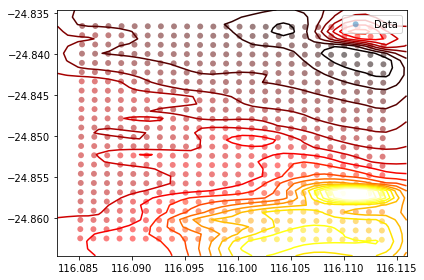

In [12]:
f = model.plot()
plt.savefig('/Users/davidkohn/Desktop/dataset2-mag.png')

# Dataset3: grav_north

fpath: /Users/davidkohn/dev/obsidian/data/dataset3/Gascoyne_North_2010_gravity_line_data_all.xlsx
  Data shape: (8221, 28)
  Data columns: Index(['GA PROJECT NUMBER', 'GA STATION NUMBER', 'OBSERVATION TYPE',
       'COORDINATE LATITUDE GDA94 (DECIMAL DEGREES)',
       'COORDINATE LONGITUDE GDA94 (DECIMAL DEGREES)',
       'COORDINATE EASTING MGA/GDA94 (M)', 'COORDINATE NORTHING MGA/GDA94 (M)',
       'COORDINATE ELEVATION ELLIPSOIDAL GRS80 (M)',
       'GEOID ELLIPSOID SEPARATION AUSGEOID98 (M)',
       'GROUND LEVEL ELEVATION (M)', 'OBSERVED GRAVITY AAGD07 (GU)',
       'STATION HEIGHT OF GRAVITY METER (M)',
       'INNER ZONE TERRAIN CORRECTION (GU)',
       'QUALITY FACTOR OF INNER ZONE TERRAIN CORRECTION',
       'OUTER ZONE TERRAIN CORRECTION (GU)',
       'QUALITY FACTOR OF OUTER ZONE TERRAIN CORRECTION',
       'TOTAL TERRAIN CORRECTION (GU)', 'ELLIPSOIDAL FREE AIR ANOMALY (GU)',
       'SPHERICAL CAP BOUGUER ANOMALY 2.67 t/m^3 (GU)',
       'COMPLETE SPHERICAL CAP BOUGUER ANOMA

 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


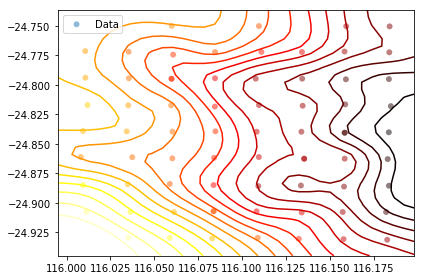

In [17]:
dict_data_set = dict_data_set3
sub_key = 'grav_north'
length = 0.10

fpath_data, key_x_coord, key_y_coord, key_y = get_vars(dict_data_set, sub_key)
data = get_data(fpath_data, ftype = 'xlsx')

data_centred = get_data_that_is_in_square_around_centre(
    data,
    [lon_centre, lat_centre],
    [key_x_coord, key_y_coord],
    [length, length]
)

data_centred[key_y] = data_centred[key_y] - data_centred[key_y].mean()

X, Y, model = run_gp(data_centred, key_x_coord, key_y_coord, key_y)

# Dataset3: mag1

In [20]:
headers = [
    'line',
    'flight',
    'direction',
    'date',
    'fiducial',
    'time',
    'recovery status',
    'easting',
    'northing',
    'longitude',
    'latitude',
    'mag raw',
    'igrf',
    'dirunal',
    'mag corrected',
    'total count raw',
    'potassium raw',
    'uranium raw',
    'thorium raw',
    'cosmic',
    'total count corrected',
    'potassium corrected',
    'uranium corrected',
    'thorium corrected',
    'radar altimeter',
    'barometric altimeter',
    'gps height',
    'end'
]

centres: [116.09860047555166, -24.85128476877929]
keys: ['longitude', 'latitude']
lengths: [0.015, 0.015]
data.shape before: (9441046, 28)
data.shape after: (2670, 29)
Running GP
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    13s80  0007   2.204632e+06   8.631843e+11 
    25s85  0013   3.340956e+05   4.252508e+09 
    32s01  0016   1.463459e+05   1.138992e+09 
    45s96  0023   4.074661e+04   1.661011e+08 
    51s82  0026   2.255659e+04   2.268716e+05 
 01m01s80  0031   1.356511e+04   1.448071e+05 
 01m14s04  0037   1.231692e+04   2.867998e+02 
 01m53s19  0057   1.064675e+04   1.411319e+05 
Runtime:  01m53s19
Optimization status: Converged


Name : GP regression
Objective : 10646.754810930017
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  Mat32.variance           |  4287.24499298  |      +ve      |        
  Mat32.lengthsca

 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /Users/davidkohn/anaconda2/envs/ipy361/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


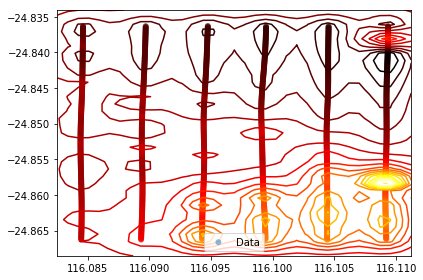

In [21]:
dict_data_set = dict_data_set3
sub_key = 'mag1'
length = length_mag
#length = 2000

fpath_data, key_x_coord, key_y_coord, key_y = get_vars(dict_data_set, sub_key)
data = pd.read_csv(fpath_data, sep = '\s+', header = None)
data.columns = headers

data_centred = get_data_that_is_in_square_around_centre(
    data,
    [agd_x_centre, agd_y_centre],
    [key_x_coord, key_y_coord],
    [length, length]
)

data_centred[key_y] = data_centred[key_y] - data_centred[key_y].mean()

new_key_x_coord = 'lon'
new_key_y_coord = 'lat'

data_centred[new_key_x_coord] = 0
data_centred[new_key_y_coord] = 0
for idx, (x, y) in enumerate(zip(data_centred[key_x_coord], data_centred[key_y_coord])):
    lon, lat = pyproj.transform(mgaz50, gda94, x, y)
    data_centred.loc[idx, new_key_x_coord] = lon
    data_centred.loc[idx, new_key_y_coord] = lat

X, Y, model = run_gp(data_centred, key_x_coord, key_y_coord, key_y, ARD = True)

In [ ]:
f = model.plot()
plt.savefig('/Users/davidkohn/Desktop/dataset3-mag-length-20km-ard.png')